In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [211]:
data = pd.read_csv("LiverDamage_NHANES.csv")
data = data.drop("SEQN", axis=1)

y = data["LiverDamage"]
X = data.drop("LiverDamage", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_train.shape

(5604, 19)

In [84]:

num_pipeline = Pipeline([("imputer", SimpleImputer(strategy="median")),
                         ("scaler", StandardScaler())])
cat_pipeline = Pipeline([("imputer", SimpleImputer(strategy="most_frequent"))])
num_attribs = ["LBXSATSI", "Age", "ReadyMeals", "FrozenMeals", "AvgAlc12Month", "MinSedentary"]
cat_attribs = ["Gender", "CountryOB", "DietHealth", "MilkConumption", "Cigs100", "DrinkEveryday", "VigWork", "ModWork", "TravelBikeWalk", "VigRec", "ModRec", "YEARS"]

col_transform = ColumnTransformer([("num", num_pipeline, num_attribs),
                                   ("cat", cat_pipeline, cat_attribs)])

k_folds = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)
knn_model = Pipeline([("transformer", col_transform),
                      ("classifier", KNeighborsClassifier())])
knn_scores = cross_val_score(knn_model, X_train, y_train, cv=k_folds)
print(knn_scores.mean(), knn_scores.std())


0.9423618898942273 0.004141098016484265


In [85]:
from sklearn.model_selection import GridSearchCV

knn_param_grid = {"classifier__n_neighbors": np.arange(1, 10),
                  "classifier__weights": ["uniform", "distance"]}

knn_grid_cv = GridSearchCV(knn_model, knn_param_grid, scoring="accuracy", n_jobs=-1, cv=k_folds)

In [86]:
%%time
knn_grid_cv.fit(X_train, y_train);

CPU times: total: 1.5 s
Wall time: 5.9 s


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=0),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['LBXSATSI',
                                                                          'Age',
                                                                          'ReadyMeals',
                                                                          'FrozenMeals',
  

In [100]:
from sklearn.metrics import accuracy_score

knn_model.fit(X_train, y_train)
y_test_predicted = knn_model.predict(X_test)
accuracy_score(y_test, y_test_predicted)

0.9408825978351374

In [88]:
knn_grid_cv.best_params_

{'classifier__n_neighbors': 6, 'classifier__weights': 'distance'}

In [89]:
knn_grid_cv.best_score_

0.9435513041077269

In [90]:
cv_results = pd.DataFrame(knn_grid_cv.cv_results_).sort_values("mean_test_score", ascending=False)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_neighbors,param_classifier__weights,params,split0_test_score,split1_test_score,split2_test_score,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
11,0.029400,0.002444,0.210800,0.013212,6,distance,"{'classifier__n_neighbors': 6, 'classifier__we...",0.949153,0.943800,0.946476,...,0.949153,0.940179,0.943800,0.939340,0.944692,0.952721,0.934821,0.943551,0.004859,1
7,0.029533,0.003481,0.212914,0.012490,4,distance,"{'classifier__n_neighbors': 4, 'classifier__we...",0.946476,0.942908,0.943800,...,0.944692,0.946429,0.950045,0.935772,0.941124,0.949153,0.938393,0.943136,0.004353,2
5,0.029600,0.002444,0.207067,0.015308,3,distance,"{'classifier__n_neighbors': 3, 'classifier__we...",0.948260,0.944692,0.939340,...,0.942908,0.946429,0.947368,0.937556,0.941124,0.946476,0.938393,0.942600,0.004221,3
4,0.033807,0.007313,0.221768,0.015459,3,uniform,"{'classifier__n_neighbors': 3, 'classifier__we...",0.948260,0.943800,0.939340,...,0.942016,0.946429,0.947368,0.937556,0.942016,0.945584,0.938393,0.942362,0.004134,4
8,0.030667,0.005250,0.224968,0.016075,5,uniform,"{'classifier__n_neighbors': 5, 'classifier__we...",0.948260,0.943800,0.946476,...,0.944692,0.940179,0.943800,0.937556,0.941124,0.950045,0.937500,0.942362,0.004141,5


In [91]:
pivoted_cv_results = cv_results.pivot_table(values="mean_test_score",
                                            index=["param_classifier__n_neighbors"],
                                            columns=["param_classifier__weights"])
pivoted_cv_results

param_classifier__weights,distance,uniform
param_classifier__n_neighbors,,
1,0.936414,0.936414
2,0.936414,0.933678
3,0.942600,0.942362
4,0.943136,0.935522
5,0.942243,0.942362
6,0.943551,0.935403
7,0.939745,0.939686
8,0.940994,0.935046
9,0.938139,0.938139


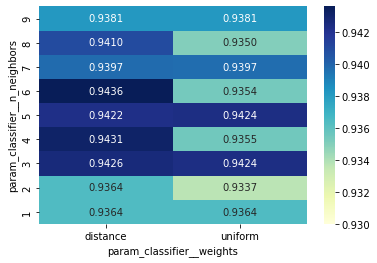

In [97]:
ax = sns.heatmap(pivoted_cv_results, annot=True, fmt=".4f", cmap="YlGnBu", vmin=0.93, vmax=0.9436)
ax.invert_yaxis()

In [140]:
from sklearn.base import BaseEstimator, TransformerMixin

# corresponding index in the list of numerical columns (num_attribs) passed to ColumnTransformer
sibsp_ix, parch_ix = 1, 2


class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_family_info = True):
        self.add_family_info = add_family_info
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.add_family_info:
            family_size = X[:, sibsp_ix] + X[:, parch_ix] + 1
            alone = [1 if i==1 else 0 for i in family_size]
            return np.c_[X, family_size, alone]
        else:
            return np.c_[X]

In [141]:
num_pipeline = Pipeline([("imputer", SimpleImputer(strategy="median")),
                         ('attribs_adder', CombinedAttributesAdder()),
                         ("scaler", StandardScaler())
                        ])

cat_pipeline = Pipeline([("imputer", SimpleImputer(strategy="most_frequent"))])

col_transform = ColumnTransformer([("num", num_pipeline, num_attribs),
                                   ("cat", cat_pipeline, cat_attribs)])

In [142]:
fs_k_best = Pipeline([("transformer", col_transform),
                      ("selector", SelectKBest(f_classif, k=6))
                     ])

In [143]:
fs_k_best.fit(X_train, y_train)

C:\Users\jacko\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [7] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\jacko\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['LBXSATSI', 'Age',
                                                   'ReadyMeals', 'FrozenMeals',
                                                   'AvgAlc12Month',
                                                   'MinSedentary']),
                                                 ('cat',
                                           

In [144]:
fs_k_best[-1].get_support()

array([ True,  True, False, False,  True, False,  True, False, False,
        True,  True, False, False, False, False, False, False, False,
       False, False])

In [145]:
fs_k_best[-1].pvalues_

array([0.00000000e+00, 1.92581928e-06, 9.04954079e-01, 7.65993521e-01,
       2.54827727e-06, 5.65649620e-01, 6.47985848e-06,            nan,
       5.87580042e-01, 9.18113255e-03, 1.64179733e-08, 7.89427594e-01,
       5.80113347e-01, 1.15235693e-01, 2.68389856e-01, 4.38283499e-01,
       6.67259486e-01, 4.18509064e-01, 4.38283499e-01, 5.28107079e-01])

In [149]:
cat_encoder = fs_k_best[0].named_transformers_["cat"]
cat_one_hot_attribs = []
for i in range(len(list(X_train.columns.values))):
    cat_one_hot_attribs += list(X_train.columns.values)[i]
attributes = list(X_train.columns.values)
sorted(zip(fs_k_best[-1].pvalues_, attributes), reverse=False)    

[(0.0, 'LBXSATSI'),
 (1.6417973326653293e-08, 'AvgAlc12Month'),
 (1.9258192796109577e-06, 'Gender'),
 (2.5482772685130427e-06, 'DietHealth'),
 (6.479858481418974e-06, 'TakeoutMeals'),
 (0.009181132554248683, 'Cigs100'),
 (0.11523569279020142, 'ModWork'),
 (0.2683898561892217, 'TravelBikeWalk'),
 (0.41850906386472697, 'MinSedentary'),
 (0.4382834990757992, 'VigRec'),
 (0.4382834990757992, 'YEARS'),
 (0.5656496196767045, 'MilkConumption'),
 (0.5801133470216737, 'VigWork'),
 (0.5875800420629109, 'FrozenMeals'),
 (0.6672594856750855, 'ModRec'),
 (0.7659935210615376, 'CountryOB'),
 (0.904954079090905, 'Age'),
 (nan, 'ReadyMeals'),
 (0.7894275941322028, 'DrinkEveryday')]

In [210]:
data = pd.read_csv("LiverDamage_NHANES.csv")

to_drop = ['ModWork',
'TravelBikeWalk',
'MinSedentary',
'VigRec',
'YEARS',
'MilkConumption',
'VigWork',
'FrozenMeals',
'ModRec',
'CountryOB',
'Age',
'ReadyMeals',
'DrinkEveryday']

data = data.drop("SEQN", axis=1)
data = data.drop(to_drop, axis=1)


y = data["LiverDamage"]
X = data.drop("LiverDamage", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_train.shape

(5604, 6)

In [154]:
num_pipeline = Pipeline([("imputer", SimpleImputer(strategy="median")),
                         ("scaler", StandardScaler())])
cat_pipeline = Pipeline([("imputer", SimpleImputer(strategy="most_frequent"))])
num_attribs = ["LBXSATSI", "AvgAlc12Month", "TakeoutMeals"]
cat_attribs = ["Gender", "DietHealth", "Cigs100"]

col_transform = ColumnTransformer([("num", num_pipeline, num_attribs),
                                   ("cat", cat_pipeline, cat_attribs)])

k_folds = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)
knn_model = Pipeline([("transformer", col_transform),
                      ("classifier", KNeighborsClassifier())])
knn_scores = cross_val_score(knn_model, X_train, y_train, cv=k_folds)
print(knn_scores.mean(), knn_scores.std())

0.9773370396329806 0.004285917303477889


In [155]:
from sklearn.model_selection import GridSearchCV

knn_param_grid = {"classifier__n_neighbors": np.arange(1, 10),
                  "classifier__weights": ["uniform", "distance"]}

knn_grid_cv = GridSearchCV(knn_model, knn_param_grid, scoring="accuracy", n_jobs=-1, cv=k_folds)

In [156]:
%%time
knn_grid_cv.fit(X_train, y_train);

CPU times: total: 422 ms
Wall time: 3.36 s


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=0),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['LBXSATSI',
                                                                          'AvgAlc12Month',
                                                                          'TakeoutMeals']),
                                                                        ('cat

In [157]:
from sklearn.metrics import accuracy_score

knn_model.fit(X_train, y_train)
y_test_predicted = knn_model.predict(X_test)
accuracy_score(y_test, y_test_predicted)

0.9758534554537885

In [158]:
knn_grid_cv.best_params_

{'classifier__n_neighbors': 4, 'classifier__weights': 'distance'}

In [159]:
knn_grid_cv.best_score_

0.9801923771292637

In [160]:
cv_results = pd.DataFrame(knn_grid_cv.cv_results_).sort_values("mean_test_score", ascending=False)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_neighbors,param_classifier__weights,params,split0_test_score,split1_test_score,split2_test_score,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
7,0.016800,0.002072,0.014267,0.001611,4,distance,"{'classifier__n_neighbors': 4, 'classifier__we...",0.984835,0.978591,0.979483,...,0.982159,0.975893,0.981267,0.982159,0.975914,0.984835,0.978571,0.980192,0.003804,1
11,0.016933,0.000998,0.018067,0.001436,6,distance,"{'classifier__n_neighbors': 6, 'classifier__we...",0.984835,0.979483,0.980375,...,0.981267,0.975000,0.980375,0.981267,0.974130,0.984835,0.977679,0.979776,0.003566,2
5,0.016600,0.000611,0.013667,0.000943,3,distance,"{'classifier__n_neighbors': 3, 'classifier__we...",0.986619,0.977698,0.975914,...,0.977698,0.977679,0.980375,0.980375,0.974130,0.984835,0.979464,0.979419,0.003749,3
9,0.017133,0.000806,0.016667,0.000943,5,distance,"{'classifier__n_neighbors': 5, 'classifier__we...",0.984835,0.978591,0.976806,...,0.981267,0.975893,0.981267,0.980375,0.976806,0.983943,0.975893,0.978884,0.003696,4
13,0.017466,0.002247,0.019467,0.001586,7,distance,"{'classifier__n_neighbors': 7, 'classifier__we...",0.983943,0.979483,0.973238,...,0.979483,0.974107,0.980375,0.980375,0.977698,0.982159,0.977679,0.978824,0.003299,5


In [161]:
pivoted_cv_results = cv_results.pivot_table(values="mean_test_score",
                                            index=["param_classifier__n_neighbors"],
                                            columns=["param_classifier__weights"])
pivoted_cv_results

param_classifier__weights,distance,uniform
param_classifier__n_neighbors,,
1,0.978408,0.978408
2,0.978349,0.972579
3,0.979419,0.977754
4,0.980192,0.972816
5,0.978884,0.977337
6,0.979776,0.972935
7,0.978824,0.975493
8,0.978051,0.970318
9,0.977873,0.973173


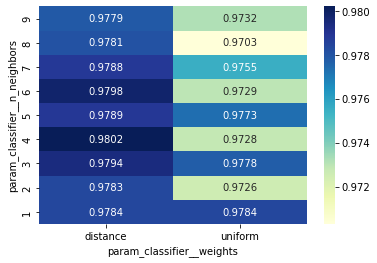

In [166]:
ax = sns.heatmap(pivoted_cv_results, annot=True, fmt=".4f", cmap="YlGnBu", vmin=0.9703, vmax=0.9802)
ax.invert_yaxis()

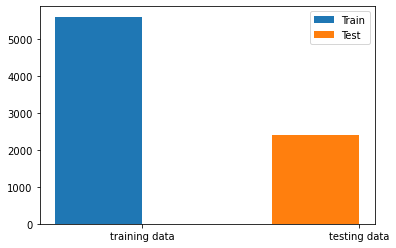

In [204]:
name = ['training data', 'testing data']
trainD = [len(X_train), 0]
testD = [0, len(X_test)]

x_axis = np.arange(len(name))

# Multi bar Chart

plt.bar(x_axis -0.2, trainD, width=0.4, label = 'Train')
plt.bar(x_axis -0.2, testD, width=0.4, label = 'Test')
plt.xticks(x_axis, name)

# Add legend

plt.legend()

# Display

plt.show()